In [49]:
import sys

#sys.executable
#sys.path.append('/export/home/lpnguye3/anaconda3_gp2/envs/floes/lib/python3.5/site-packages')

In [50]:
import pyemma

# Requirements

Add the conda-forge software channel, and install (or update) PyEMMA:
```bash
conda config --add channels conda-forge
conda install pyemma
```

# Featurization

Import the [pyEMMA coordinates](http://emma-project.org/latest/api/index_coor.html).
>  This package contains functions and classes for reading and writing trajectory files, extracting order parameters from them (such as distances or angles), as well as various methods for dimensionality reduction and clustering.

In [51]:
import pyemma.coordinates as coor
import numpy as np
import glob 
import mdtraj as md
import math
from matplotlib import gridspec
from sklearn.metrics import silhouette_samples, silhouette_score
from pyemma.plots import plot_free_energy
from scipy import stats

In [52]:
#Set the Variables needed to run the notebook

# Set the Ligand Name
lig_name = '6N6_1'

# Set the dt found in the log file
dt = 40

# Set the PDB File Name
pdbfile = '6N6_1_0_c4-13066319-centered.pdb'

# Set the file naming convention to load all the needed trajectories
name_pattern = '6N6_1_0_c*-centered.nc'

# Set the prefix for the Trajector Frame .dcd file output
dcdFprefix = '6N6_1-left'

From the coordinates module, use the [featurizer](http://emma-project.org/latest/api/generated/pyemma.coordinates.featurizer.html#pyemma.coordinates.featurizer) to select the ligand heavy atoms.

In [53]:
#Select features to analyze in trajectory

trajfiles = glob.glob(name_pattern)
print(len(trajfiles))
feat = coor.featurizer(pdbfile)

lig_atoms = feat.select("resname LIG and not type H")
feat.add_selection(lig_atoms)
inp = coor.source(trajfiles, feat)

print('Selected %s heavy atoms' % len(lig_atoms))

19


HBox(children=(HBox(children=(Label(value='Obtaining file info'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

Selected 11 heavy atoms


Load the coordinates from disc. Often, coordinates will not fit into memory, so we'll just create a loader by specifying the files as follows using the [source module](http://emma-project.org/latest/api/generated/pyemma.coordinates.source.html):

In [54]:
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

number of trajectories =  19
trajectory length =  5000
number of dimension =  33


# Dimensionality Reduction
## time-lagged independent component analysis (TICA)
[TICA theory](http://docs.markovmodel.org/lecture_tica.html)

Run TICA for a series of lag times and select a suitable lag time for further analysis. In order to do so, have a look at the implied timescales generated by TICA. The [TICA object](http://emma-project.org/latest/api/generated/pyemma.coordinates.tica.html#pyemma.coordinates.tica) has an attribute timescales.



In [55]:
#Frames in MD simulation were taken every 10ps 
#Give a range of different lag times to try out
lag_list = np.arange(1, 20,5)
nlags = lag_list.shape[0]

In [56]:
#Load the trajectory files
Y = inp.get_output()
print("type of Y:", type(Y))
print("length of Y:", len(Y))
print("shape of first element:", Y[0].shape)

HBox(children=(HBox(children=(Label(value='getting output of FeatureReader'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

type of Y: <class 'list'>
length of Y: 19
shape of first element: (5000, 33)


In [57]:
#Try out different lag times fr 
lag_times = []
for lag in lag_list:
    data = coor.tica(np.vstack(Y),lag, kinetic_map=True, var_cutoff=0.95, reversible=True)
    lag_times.append(data.timescales[:10])
lag_times = np.asarray(lag_times)

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Timescales [$ps$]')

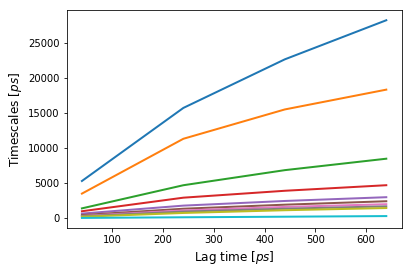

In [59]:
#Plot the different lag times
plt.plot(dt*lag_list, dt*lag_times, linewidth=2)
plt.xlabel(r"Lag time [$ps$]", fontsize=12)
plt.ylabel(r"Timescales [$ps$]", fontsize=12)

In [60]:
#Select a lag time where the lines start to level off
#Here, I'll use 80ps
lag = np.int(1000/ dt)
tica_obj = coor.tica(inp, lag=lag, kinetic_map=True, var_cutoff=0.95, reversible=True)
print('TICA dimension ', tica_obj.dimension())
print('CUMVAR', tica_obj.cumvar)

HBox(children=(HBox(children=(Label(value='calculate covariances'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

TICA dimension  9
CUMVAR [ 0.16427054  0.3233686   0.4679244   0.59136594  0.6939974   0.78602237
  0.86514357  0.9358099   0.99623621  0.99782355  0.99877329  0.99919146
  0.99943798  0.99958039  0.99966672  0.99972582  0.99977217  0.99981189
  0.99984983  0.99987983  0.99990691  0.9999297   0.9999465   0.99996202
  0.99997358  0.99998238  0.99998859  0.99999425  0.99999751  0.99999893
  0.99999933  0.9999997   1.        ]


Plot the first two TICA components. The TICA object has a get_output() method.

In [61]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

HBox(children=(HBox(children=(Label(value='getting output of TICA'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

number of trajectories =  19
number of frames =  5000
number of dimensions =  9


PyEMMA has a [plotting module](http://emma-project.org/latest/api/index_plots.html#plots-plotting-tools-pyemma-plots) which we can use to plot the TICA coordinates

In [62]:
from pyemma import plots

Text(0,0.5,'TIC 2')

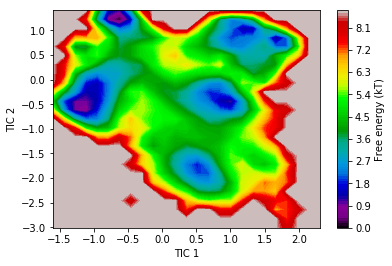

In [63]:
plots.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], nbins=25)
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')

# Clustering the data

## K-means clustering
Use [k-means clustering](http://emma-project.org/latest/api/generated/pyemma.coordinates.clustering.KmeansClustering.html#pyemma.coordinates.clustering.KmeansClustering) and get the discrete trajectories

In [64]:
new_k = int(math.sqrt(np.shape(Y)[1])+100)
cl = coor.cluster_kmeans(data=Y, max_iter=100, k=new_k)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:, 0]
cc_y = cl.clustercenters[:, 1]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=170), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

28-11-18 21:20:59 pyemma.coordinates.clustering.kmeans.KmeansClustering[50] INFO     Cluster centers converged after 16 steps.


HBox(children=(HBox(children=(Label(value='getting output of KmeansClustering'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

Visualize the clusters

Text(0,0.5,'TIC 2')

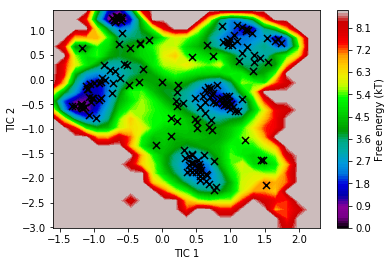

In [65]:
plots.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], nbins=25)
plt.scatter(cc_x, cc_y, marker = 'x', s=50,color = 'black')
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')

If you have time, try other clustering methods (regular space, regular time) and visualize the results. Which method do you prefer?

# Markov State Model construction
#### Theory: 
- [Implied timescales](http://docs.markovmodel.org/lecture_implied_timescales.html)
- Pande, V. S., K. A. Beauchamp, and G. R. Bowman. [Everything you wanted to know about Markov State Models but were afraid to ask](http://www.sciencedirect.com/science/article/pii/S1046202310001568?via%3Dihub)
 Methods 52.1 (2010): 99-105
Let's estimate MSMs at different lagtimes. Now we would like the lagtime to converge within the statistical uncertainty.

This function estimates an MSM for each of the lag-times we have provided: $\tau=n_{lag}\cdot t_{\text{stride}}$ Where $n_{lag}$ is one of the integers given in the lags list, and  $t_{\text{stride}}$ is the trajectory time-stride. For the example data given here the last parameter is $80\,\mathrm{ps}$. The implied-timescales are then computed as:
   $$ t_i = \frac{-\tau}{\ln | \lambda_i(\tau) |}.$$
The its object contains these implied time-scales which can be plotted using one of PyEMMAs built in function for quick inspection - here you can also defined the time-units to ensure the axes express physical time.

In [66]:
from pyemma import msm

In [67]:
print(lag)
its = msm.timescales_msm(dtrajs, lags=lag, nits=10)

25


HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=8), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

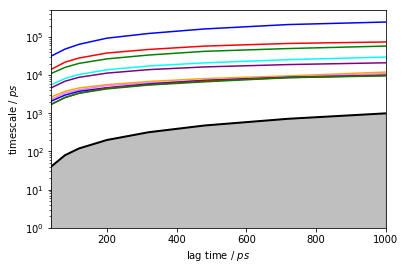

In [68]:
plots.plot_implied_timescales(its,dt=dt, units='$ps$')
plt.ylim(1,500000);

Use plots.plot_implied_timescales to visualize.

It has been shown that the implied timescales (y-axis) should be independent of the lag time (x-axis) [3]. For short lag times this is not the case, but after about 40 picoseconds, they are fairly constant. Some of the faster timescales (lower value on y-axis) either still increase as a function of lag-time or fall below the grey shaded area in the plot. This is often the case and is due to a combination of numerical issues and an imperfect discretization - this mean that the processes associated with these time-scales will be unreliable. The grey area defines the lag-time of the model, and therefore also the time-resolution of what can be resolved. If the processess fall within this area, they are generally not resolved.

Basically - we have to make a compromise, we want to have the model which the highest time-resolution which still has implied time-scales which are lag-time independent.

Sometimes it can be useful to quantify the uncertainty of these time-scales, to get a better idea of any changes in the implied-timescales carry any statistical significance. 

**using the docstring of the its-function, try to figure out how to obtain Bayesian error estimates of the implied time-scales**

Estimate uncertainties using Bayesian sampling. Note that these errors tend to be a bit underestimated, but we can still see that the timescales are flat within the error for lag times above 40 picoseconds.

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=8), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

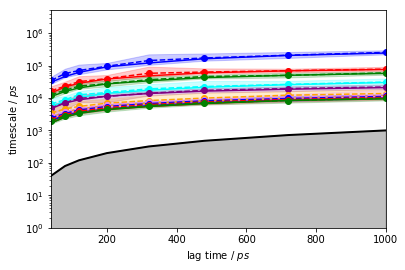

In [69]:
its = msm.timescales_msm(dtrajs, lags=lag, nits=10, errors='bayes')
plots.plot_implied_timescales(its, dt=dt, units='$ps$')
plt.ylim(1, 5000000);

Now build an MSM at a good lag time:

In [70]:
M = msm.estimate_markov_model(dtrajs, lag)

In [71]:
#Count of transitions between two states
M.count_matrix_active

array([[ 105.,    0.,    0., ...,    7.,    0.,    0.],
       [   0.,  284.,    0., ...,    0.,   38.,    0.],
       [   0.,    0.,  697., ...,    0.,    0.,    0.],
       ..., 
       [   0.,    0.,    0., ...,  242.,    0.,    2.],
       [   0.,   52.,    0., ...,    0.,  134.,    0.],
       [   1.,    0.,    0., ...,    0.,    0.,  115.]])

## Silhouette Scoring to determine number of clusters

In [72]:
def get_color_list(num_colors, cmap='gist_rainbow'):
    """Returns N colors according to the provided colormap.

    Parameters:
    -----------
    n_clusters : int, the number of metastable states/clusters
    cmap : str, specifying the matplotlib colormap to use.

    Returns:
    --------
    colors : list, containing the colors for each cluster.
    """
    colormap = plt.get_cmap(cmap)
    colors = [colormap(1.*i/num_colors) for i in range(num_colors)]
    return colors

In [73]:
def plotSilhouette(ax1, ax2, n_clusters, pcca_sets, cluster_labels, centers,
                  silhouette_avg, sample_silhouette_values, tica_coordinates, cmap='gist_rainbow'):
    """
    Function to plot the silhouette scores next to the clusters resulting from
    PCCA++ projected onto the TICA coordinates.

    Parameters:
    -----------
    ax1, ax2 : matplotlib.axes.Axes
               `ax1` contains the figure for the silhoutte plots.
               `ax2` contains the figure for the clusters from PCCA++.
    n_clusters : int, number of clusters
    pcca_sets : list of arrays, the metastable sets of active set states
                within each metastable set using PCCA++. Each element is an
                array with the microstate indexes.
    cluster_labels : numpy array, assignment of active set states to the
                    metastable sets from PCCA++.
    centers : numpy array, contains the coordinates of the cluster centers
              from the active set states.
    silhouette_avg : float, average of silhouette coefficients for individual clusters.
    sample_silhouette_values : numpy array, silhouette score of individual frames.
    cmap : str, specifying the matplotlib colormap to use.
    """

    # The 1st subplot is the silhouette plot
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(centers) + (n_clusters + 1) * 10])
    y_lower = 10

    colors = get_color_list(n_clusters, cmap)
    for i, color in enumerate(colors[:n_clusters]):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Avg Silhouette Score = %0.4f" % silhouette_avg, fontweight='bold')
    ax1.set_xlabel("Silhouette Scores")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])

    # 2nd Plot showing the actual clusters formed
    plot_free_energy(np.vstack(tica_coordinates)[:, 0], np.vstack(tica_coordinates)[:, 1],
                            ax=ax2, cmap='nipy_spectral', cbar=False)
    for i, color in enumerate(colors[:n_clusters]):
        ax2.scatter(centers[pcca_sets[i],0], centers[pcca_sets[i],1],
                   marker='X', c=color,s=200, edgecolors='black')
    ax2.set_title("%s State PCCA" %n_clusters, fontweight='bold')
    ax2.set_xlabel("TIC1")
    ax2.set_ylabel("TIC2")
    ax2.set_yticks([])
    ax2.set_xticks([])

In [74]:
def get_n_clusters(silhouette_pcca):
    """Helper function that selects the appropriate number of
    metastable states from the silhouette scores. Opts to use any number
    of states greater than 2 if it is within error (by ttest).

    Parameters:
    -----------
    silhouette_pcca : dict, dictionary containing silhouette scores of PCCA assignments

    Returns:
    -------
    n_clusters : int, suggested number of clusters.
    """

    s_score_avg = [v['AVG'] for k,v in sorted(silhouette_pcca.items())]
    s_score_std = [v['STD'] for k,v in sorted(silhouette_pcca.items())]
    range_n_clusters = [k for k in sorted(silhouette_pcca.keys())]

    max0 = np.argmax(s_score_avg)
    # check if next highest is significantly different
    max1 = np.partition(s_score_avg, -2)[-2]
    max1 = int(np.argwhere(s_score_avg == max1)[0])
    print('\tInitial suggestion n_clusters = %s' % range_n_clusters[max0])
    print('\tChecking if n_clusters = %s is within error.' % range_n_clusters[max1])
    t, p = stats.ttest_ind_from_stats(s_score_avg[max0],
                                    s_score_std[max0],
                                    silhouette_pcca[range_n_clusters[max0]]['N_samples'],
                                    s_score_avg[max1],
                                    s_score_std[max1],
                                    silhouette_pcca[range_n_clusters[max1]]['N_samples'])
    if p < 0.05:
        #Even, if within error, opt for lower cluster numbers
        if range_n_clusters[max1] < range_n_clusters[max0]:
            n_clusters = range_n_clusters[max1]
             #If max gives 2 clusters, opt for higher
            if n_clusters == 2: n_clusters = range_n_clusters[max0]
        else:
            n_clusters = range_n_clusters[max0]
    else:
        n_clusters = range_n_clusters[max0]

    print('Suggested number of cluster =', n_clusters)
    return n_clusters

In [75]:
def plotNClusters(ax, silhouette_pcca, n_clusters):
    """
    Plots a barplot of the silhouette scores.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
    silhouette_pcca : dict, dictionary containing silhouette scores of PCCA assignments
    n_clusters : int, optimimal number of clusters according to silhouette scores
    outfname : str, specify the molecule name for the barplot title.
    """
    s_score_avg = [v['AVG'] for k,v in sorted(silhouette_pcca.items())]
    s_score_std = [v['STD'] for k,v in sorted(silhouette_pcca.items())]
    range_n_clusters = [k for k in sorted(silhouette_pcca.keys())]

    bar = ax.bar(range_n_clusters,s_score_avg, align='center', yerr=np.std(s_score_avg))
    bar[n_clusters-2].set_color('r')
    #ax.set_title("Silhouette analysis for PCCA clustering on %s" % outfname.split('/')[-1],
    #             fontsize=14, fontweight='bold')
    ax.set_xlabel("# clusters")
    ax.set_ylabel("<Score>")

In [76]:
def scoreSilhouette(n_clusters, centers, cluster_labels):
    """Conveience function to calculate the silhouette scores.

    Parameters:
    -----------
    n_clusters : int, number of clusters
    centers : numpy array, contains the coordinates of the cluster centers
              from the active set states.
    cluster_labels : numpy array, assignment of active set states to the
                    metastable sets from PCCA++.


    Returns:
    ---------
    silhouette_avg : float, average of silhouette coefficients for individual clusters.
    sample_silhouette_values : numpy array, silhouette score of individual frames.
    """
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(centers, cluster_labels)

    print("\tFor n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(centers, cluster_labels)
    return silhouette_avg, sample_silhouette_values

def getNumBindingModes(range_n_clusters=range(2,10), n_samples=100, tica_coords=Y, dim=None, outfname=None):
    """
    *Primary function to call.*

    Determine the likely number of binding modes by scoring the silhouettes
    of a range of different cluster numbers. Plots the silhouettes alongside
    the PCCA++ assigned clusters to a file.

    Parameters:
    ------------
    range_n_clusters : list, range of different cluster numbers to try.
    n_samples : int, number of samples to draw from PCCA distributions.
    dim : int, number of TICA coordinates to use in silhouette scoring
        default is None to use all TICA coordinates. If no clusters are not clearly,
        separated, suggest using dim=2.
    outfname : str, specifying the file prefix for saving the plots.
               Will append the suffix `<outfname>-tica_pcca.png`

    Returns:
    --------
    n_clusters : int, the optimimal number of clusters to use according to
                 the silhouette scores.
    """
    fig = plt.figure(figsize=(16, len(range_n_clusters)*5), dpi=120)
    gs = gridspec.GridSpec(len(range_n_clusters)+1, 2)

    silhouette_pcca = {}
    for idx,K in enumerate(range_n_clusters):
        pcca = M.pcca(K)
        centers = cl.clustercenters[M.active_set]
        pcca_sets = pcca.metastable_sets
        cluster_labels = pcca.metastable_assignment
        pcca_dist = M.metastable_distributions
        pcca_samples = M.sample_by_distributions(pcca_dist, n_samples)
        
        
        silhouette_avg, sample_silhouette_values = scoreSilhouette(K, centers[:,:dim], cluster_labels)

        ax1 = fig.add_subplot(gs[idx+1,0])
        ax2 = fig.add_subplot(gs[idx+1,1])
        plotSilhouette(ax1,ax2, K,pcca_sets,cluster_labels,centers,
                            silhouette_avg, sample_silhouette_values, 
                            tica_coords)

        silhouette_pcca[K] = {'PCCA_sets' : pcca_sets,
                        'Centers' : centers,
                        'Distribution' : pcca_dist,
                        'Samples' : pcca_samples,
                        'Labels': cluster_labels,
                        'N_samples' : len(sample_silhouette_values),
                        'Values': sample_silhouette_values,
                        'AVG' : silhouette_avg,
                        'STD' : np.std(sample_silhouette_values)
                        }

    n_clusters = get_n_clusters(silhouette_pcca)

    ax3 = fig.add_subplot(gs[0,:])
    plotNClusters(ax3, silhouette_pcca, n_clusters)

    gs.tight_layout(fig)
    if outfname:
        ax3.set_title("Silhouette analysis for PCCA clustering on %s" % outfname.split('/')[-1],
                     fontsize=14, fontweight='bold')
        plt.savefig('{}-tica_pcca.png'.format(outfname), bbox_inches='tight')
    else:
        ax3.set_title("Silhouette analysis for PCCA clustering",
                     fontsize=14, fontweight='bold')
        plt.show()
    plt.close(fig)
    return n_clusters, silhouette_pcca, range_n_clusters

	For n_clusters = 2 The average silhouette_score is : 0.405109
	For n_clusters = 3 The average silhouette_score is : 0.31446
	For n_clusters = 4 The average silhouette_score is : 0.500171
	For n_clusters = 5 The average silhouette_score is : 0.312998
	For n_clusters = 6 The average silhouette_score is : 0.347818
	For n_clusters = 7 The average silhouette_score is : 0.0802261
	Initial suggestion n_clusters = 4
	Checking if n_clusters = 2 is within error.
Suggested number of cluster = 4


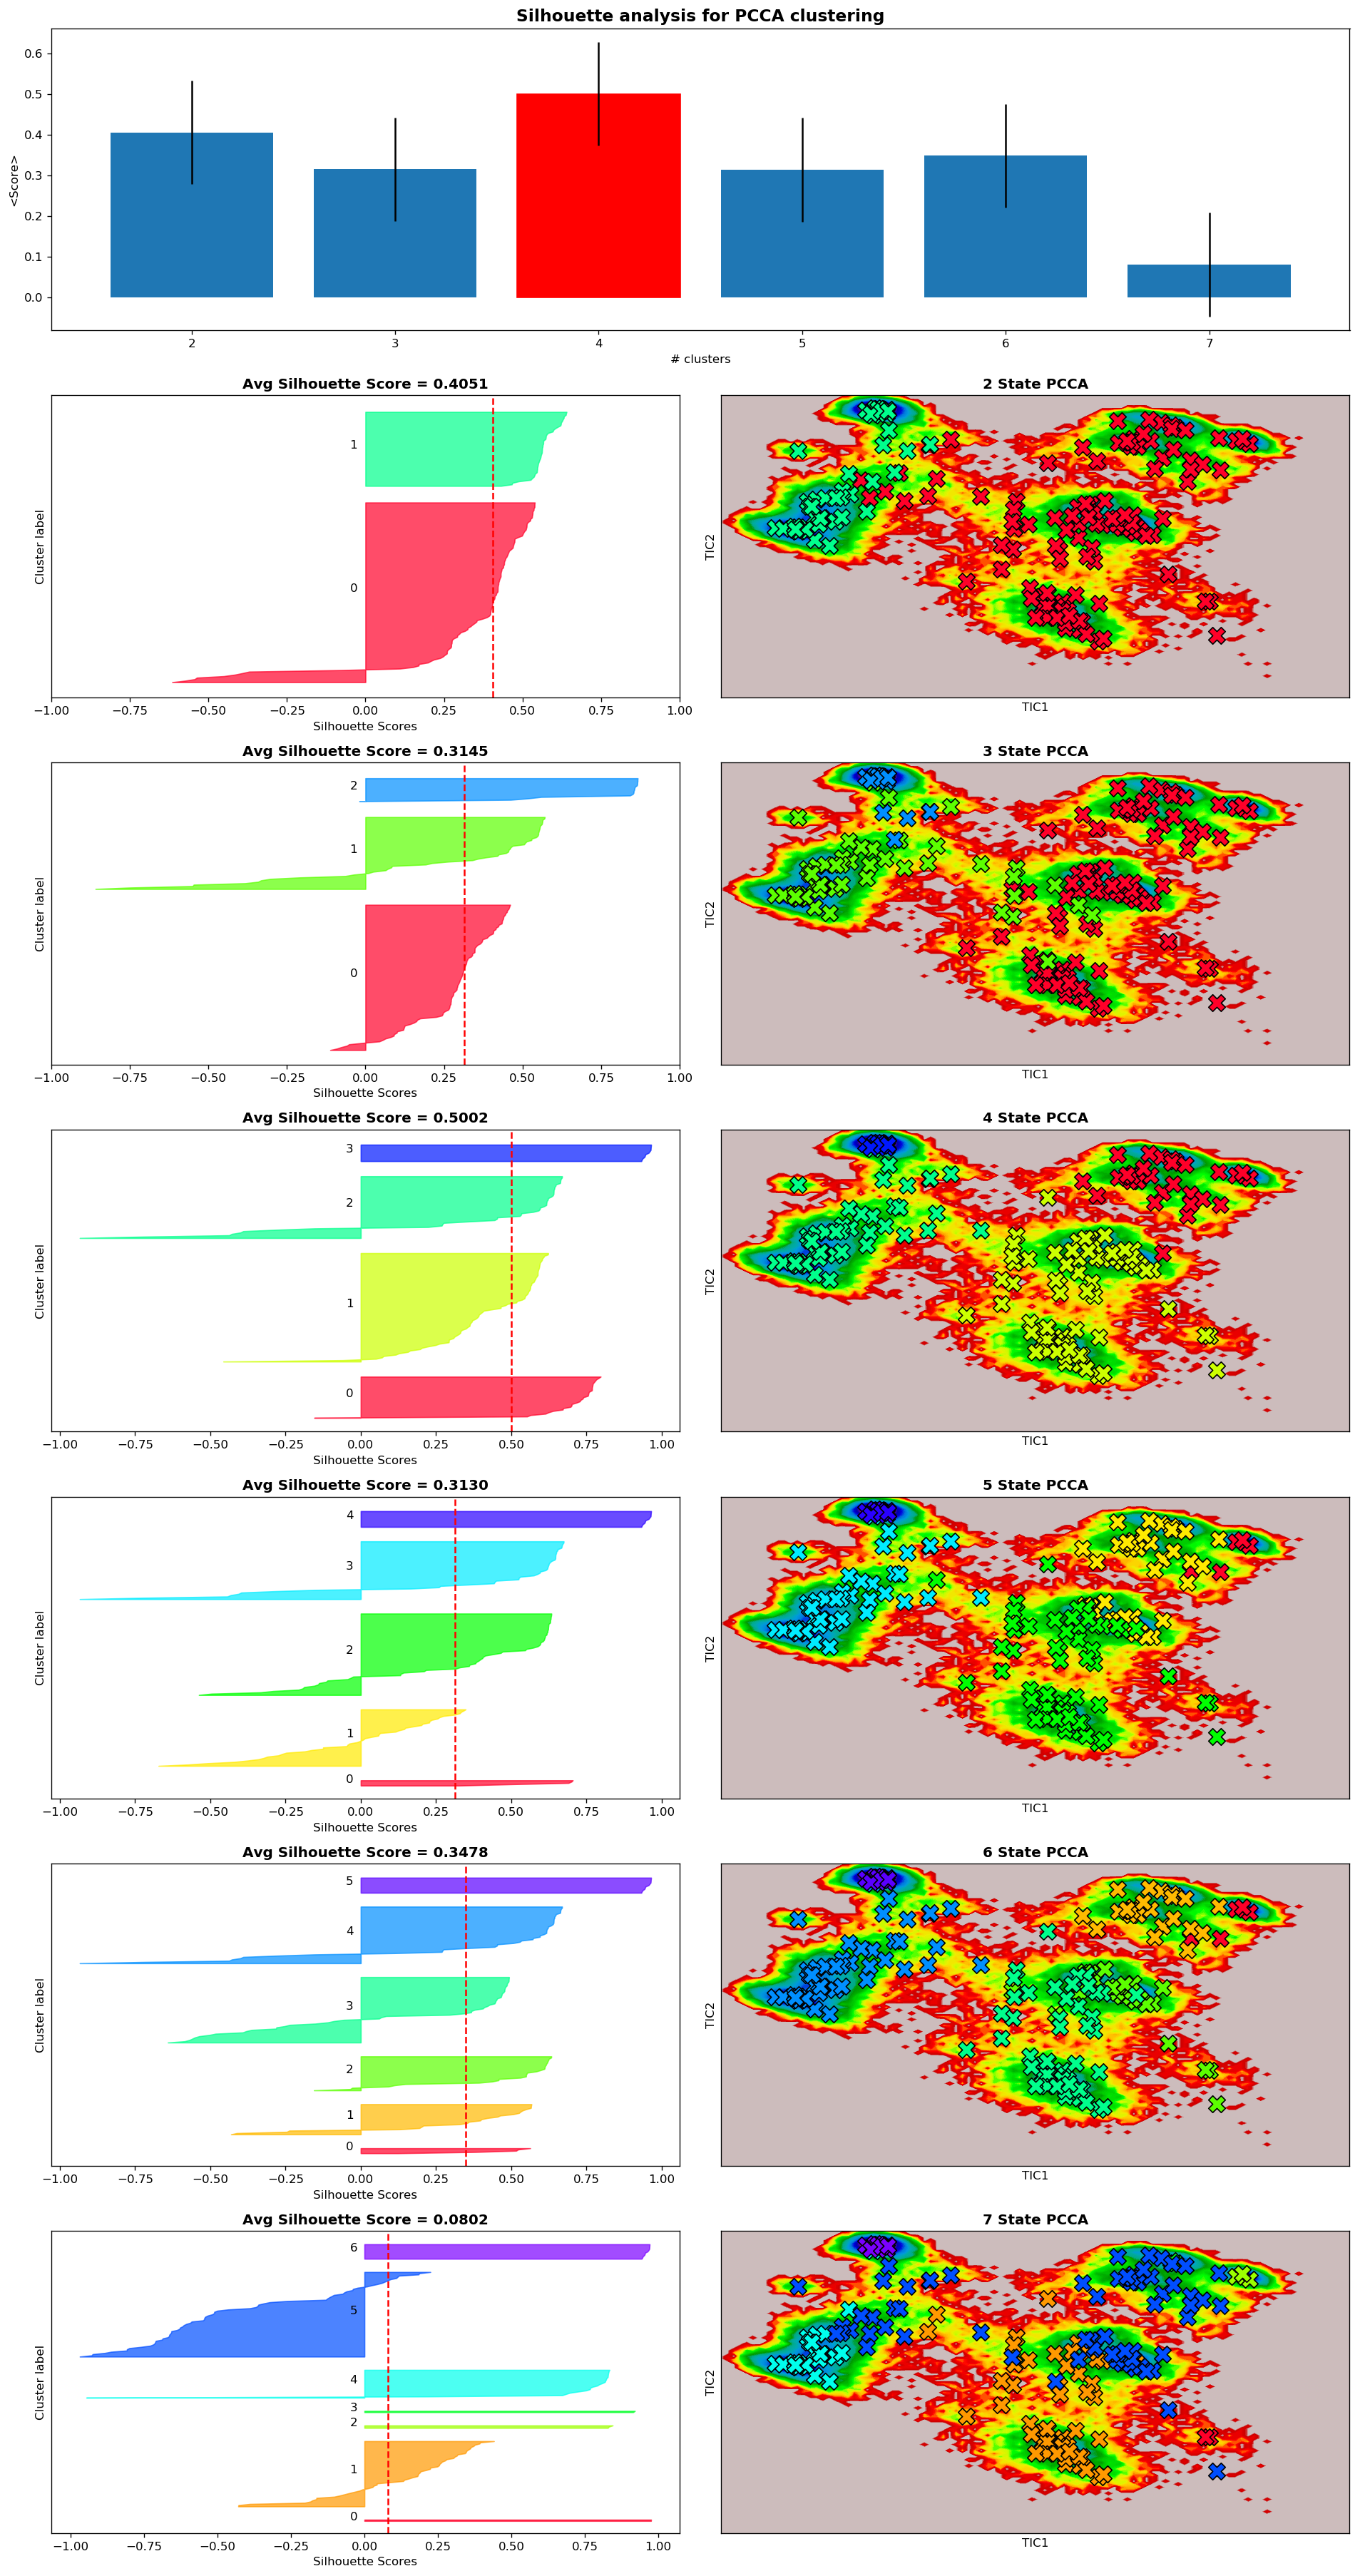

In [89]:
n_clusters, silhouette_pcca, range_n_clusters = getNumBindingModes(range_n_clusters=range(2,8), tica_coords=Y, dim=2,
                                   n_samples=100)

## Validation - Chapman-Kolmogorov test

Let's see if our Markov model fulfill the Chapman-Kolmogorov equation. This is a way of testing the self-consistency of the model. There will be more background this tomorrow morning.

The MSM instance has a method to make the testing very easy:

In [90]:
ckt = M.cktest(n_clusters)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

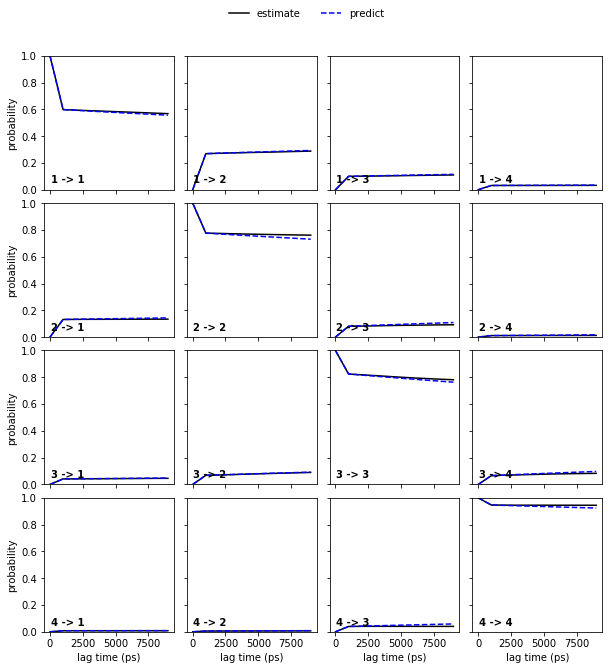

In [91]:
plots.plot_cktest(ckt,dt=dt,units="ps");

What is shown here is the predicted transition probabilities from the Markov model (blue) and corresponding ones estimated directly from the data you used to estimate the Markov model (that is, training a Markov model with a larger lag-time). More formally what we check is whether the following relation is approximately fulfilled:
$$ \underbrace{T^k(\tau)}_{\text{Markov model prediction}} \approx \underbrace{T(k\tau)}_{\text{estimation from data}} $$
where $k$ is some positive integer, and $T(\cdot)$ is a transition probability matrix for a given lag-time. Basically, we want to ensure these lines are as close as possible to each other. More depth on this topic is given tomorrow morning.


## Spectral analysis


Let us have a closer look at the timescales that were already seen in the its plot:

(-0.5, 10.5)

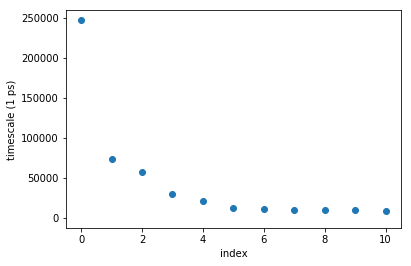

In [92]:
plt.plot(dt*M.timescales(),linewidth=0,marker='o')
plt.xlabel('index');plt.ylabel(r'timescale (1 ps)'); plt.xlim(-0.5,10.5)

## PCCA

#### Theory
- [PCCA: perron-cluster cluster analysis](http://docs.markovmodel.org/lecture_pcca.html)

Select a suitable number of metastable states and run PCCA.

In [93]:
#Perform PCCA analysis and store data
M.pcca(n_clusters)
pcca_sets = M.metastable_sets
centers = cl.clustercenters[M.active_set]
cluster_labels = M.metastable_assignments

Visualize the PCCA assignments in the free energy landscape defined by the first two TICA coordinates.
Hints: A Markov model object has an attribute M.metastable_sets. Also, you need to find out how to access the clustercenters defined in the previous step.

Text(0,0.5,'TIC 2')

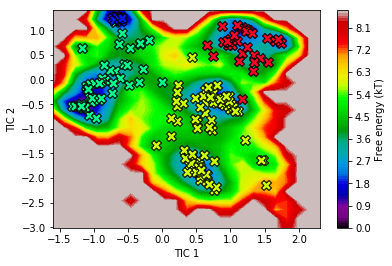

In [94]:
#Plot PCCA data
_, ax = plots.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], nbins=25)
pcca_sets = M.metastable_sets

cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/n_clusters) for i in range(n_clusters)]

for i, color in enumerate(colors[:n_clusters]):
    ax.scatter(centers[pcca_sets[i],0], centers[pcca_sets[i],1], marker='X', c=color,s=100, edgecolors='k')
ax.set_xlabel('TIC 1')
ax.set_ylabel('TIC 2')
#plt.savefig('4XH_1_c0-tiCA-PCCA.png', dpi=300,bbox_inches='tight')

### Extracting the PCCA cluster frames

In [95]:
#Extract the assigned trajectory frames from PCCA
n_samples = 100
pcca_dist = M.metastable_distributions
pcca_samples = M.sample_by_distributions(pcca_dist, n_samples)

outfiles = ['{}-pcca%s_samples.dcd'.format(dcdFprefix) % (N) for N in range(n_clusters)]
pcca_outfiles = coor.save_trajs(inp, pcca_samples, outfiles=outfiles)
print('Storing %s PCCA samples each to: \n\t%s' % (n_samples, '\n\t'.join(pcca_outfiles)))

Storing 100 PCCA samples each to: 
	6N6_1-left-pcca0_samples.dcd
	6N6_1-left-pcca1_samples.dcd
	6N6_1-left-pcca2_samples.dcd
	6N6_1-left-pcca3_samples.dcd


## Assigning frames to PCCA clusters

In [96]:
def assignTrajFramesToPCCACenters(tica_coord, pcca_centers, pcca_labels):
    """
    Given the TICA coordinates data for a trajectory, assign data to
    the nearest clsuter centers as defined from PCCA.
    Parameters:
    -----------
    tica_coord : numpy array, tica coordinates for the associated trajectory.
    pcca_centers : numpy array, contains the coordinates of the cluster centers
              from the active set states obtained from PCCA.
    pcca_labels : list, cluster assignment of the centers from PCCA.
    Returns:
    -------
    traj_cluster_labels : list of arrays, cluster assignment for each
                          trajectory frame where every array is for each trajectory
    """
    assignments = coor.assign_to_centers(tica_coord, pcca_centers)
    traj_cluster_labels = []
    for a in assignments:
        traj_cluster_labels.append(pcca_labels[a])
    return traj_cluster_labels

In [97]:
traj_cluster_labels = assignTrajFramesToPCCACenters(Y, centers, cluster_labels)

HBox(children=(HBox(children=(Label(value='getting output of AssignCenters'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [98]:
traj_cluster_labels

[array([0, 0, 0, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 3, 3, 3]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([2, 2, 2, ..., 3, 3, 3]),
 array([2, 2, 2, ..., 3, 3, 3]),
 array([2, 2, 2, ..., 0, 0, 0]),
 array([2, 2, 2, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([2, 2, 2, ..., 3, 3, 3]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 1, 1, 1]),
 array([2, 2, 2, ..., 3, 3, 3]),
 array([2, 2, 2, ..., 2, 2, 2])]

# Plotting ligand binding mode sampling with RMSD

In [99]:
def plotPoseSampling(distances,
                     cluster_labels,
                     title="Binding Mode Frequency",
                     acc_it=[], n_clusters=4,
                     cmap='gist_rainbow'):
    """Function that plots the RMSD of the ligand atoms with each frame/data point colored
    according to the cluster assignment.
    
    Parameters:
    - distances : np.array of the desired RMSD to plot
    - cluster_labels : list of the cluster assigments of the trajectory frames
    """
    
    #Define plot settings
    N = len(cluster_labels)
    plt.figure(figsize=(12, 8), dpi=300,tight_layout=True)
    f, ax = plt.subplots(2)
    
    #Get the color mappings for the number of clusters
    cm = plt.get_cmap(cmap)
    colors = [cm(1.*i/n_clusters) for i in range(n_clusters)]

    #Compute and plot the % frequency in bar plot
    labeled_frames = {n:[] for n in range(n_clusters)}
    for i, label in enumerate(cluster_labels):
        labeled_frames[label].append(i)
    freq = { key:len(val)/N*100 for key,val in labeled_frames.items() }
    rect = ax[0].bar(range(len(freq.keys())),freq.values(), align='center', color=colors)
    ax[0].set_xlabel("Ligand Binding Mode")
    ax[0].set_ylabel("% Frequency")
    ax[0].set_xticks([])
    
    #Generate a list of colors corresponding to the cluster assignment 
    colr_list = []
    for x in cluster_labels:
        colr_list.append(colors[x])
    
    #Convert frame numbers to time
    time = [0.4*t for t in range(N)]
    
    #Lineplot of RMSD relative to initial frame
    #Convert distances from nm to angstrom (distances*10.0)
    ax[1].plot(time, 10.0*distances, 'k', linewidth=0.25)
    #Colored Scatterplot points to state of minimum RMSD
    ax[1].scatter(time, 10.0*distances,c=colr_list,clip_on=False,s=25, edgecolors=None)
    
    #With BLUES, plot the vertical lines to indicate the accepted moves
    if acc_it:
        for it in acc_it:
            ax[1].axvline(x=it, color='k', linestyle='--')
            
    #Label axis        
    ax[1].set_xlabel("Time (ns)")
    ax[1].set_ylabel(r"RMSD $\AA$")
    ax[1].xaxis.grid(False)
    ax[1].yaxis.grid(False, which='major')
    plt.autoscale(enable=True, axis='both', tight=True)
    ax[0].set_title(title+" N=%s" %N)

In [100]:
def rmsdNP(traj, ref, idx):
    """Compute the RMSD wihtout trajectory alignment
    
    Parameters:
    - traj : mdtraj.Trajectory 
    - ref  : mdtraj.Trajectory  
            reference trajectory to compare `traj` object
    - idx  : list of atom inidices
    """
    return np.sqrt(3*np.sum(np.square(traj.xyz[:,idx,:] - ref.xyz[:,idx,:]),
                          axis=(1, 2))/idx.shape[0])


In [101]:
import mdtraj as md

In [ ]:
# sort the trajfiles so the Populationd digrams output in a logical order
trajfiles.sort()

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


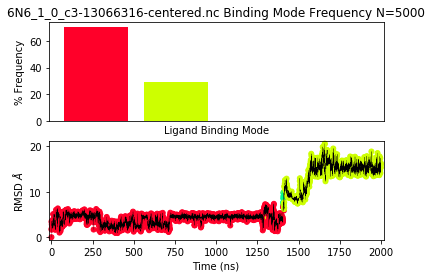

In [102]:
index = 0
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


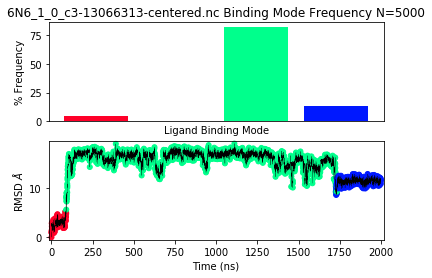

In [103]:
index = 1
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


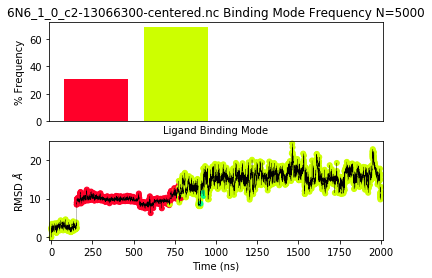

In [112]:
index = 2
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


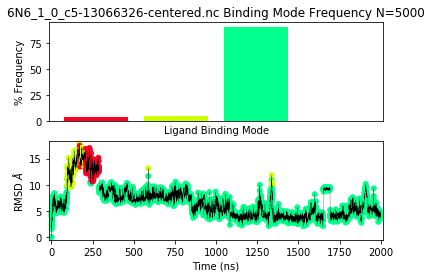

In [113]:
index = 3
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


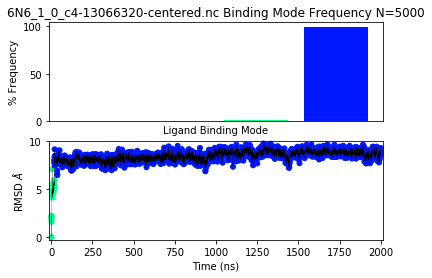

In [114]:
index = 4
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


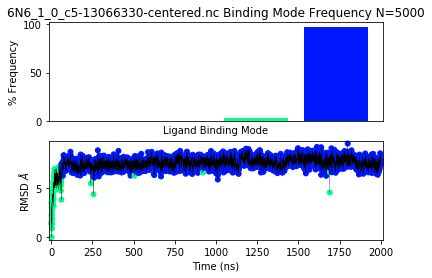

In [115]:
index = 5
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


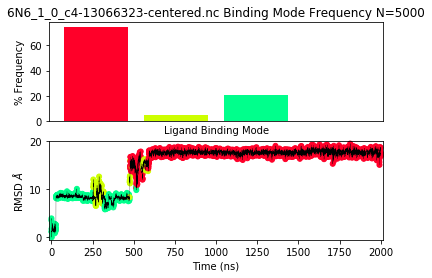

In [116]:
index = 6
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


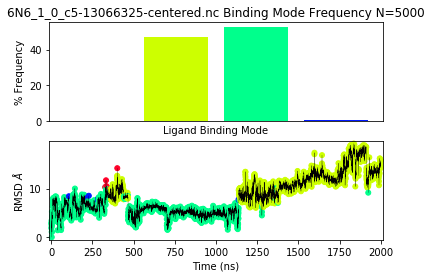

In [117]:
index = 7
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


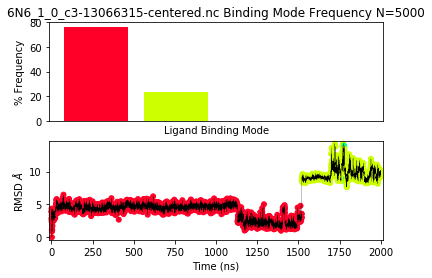

In [118]:
index = 8
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


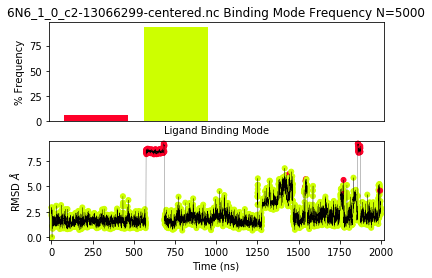

In [120]:
index = 9
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


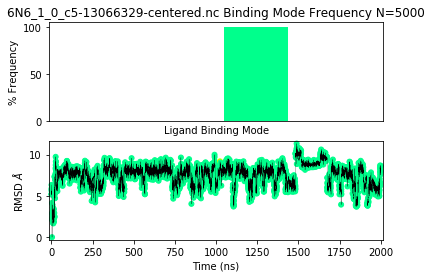

In [122]:
index = 10
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


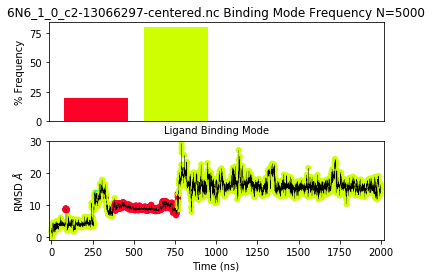

In [123]:
index = 11
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


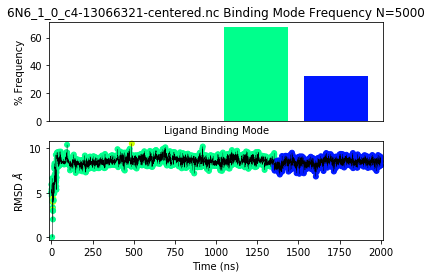

In [124]:
index = 12
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


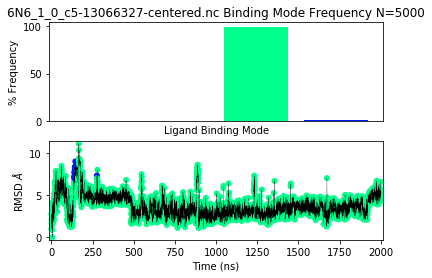

In [125]:
index = 13
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


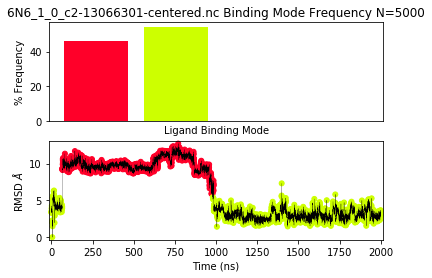

In [126]:
index = 14
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


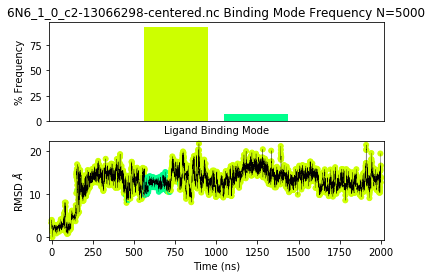

In [127]:
index = 15
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


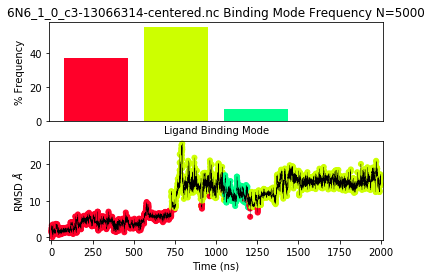

In [128]:
index = 16
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


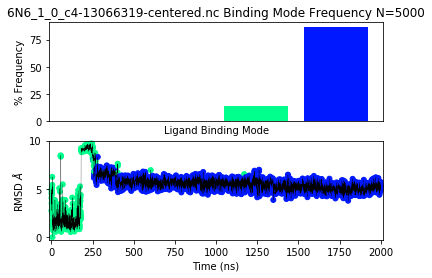

In [129]:
index = 17
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

<mdtraj.Trajectory with 5000 frames, 5131 atoms, 323 residues, and unitcells>


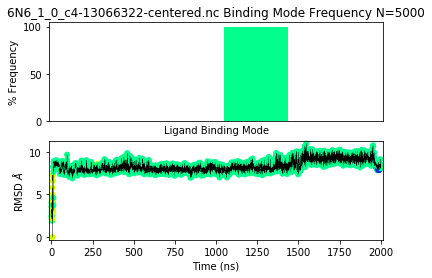

In [130]:
index = 18
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(pdbfile)
ctraj = md.load(trajfiles[index],top=pdb.top)
print(ctraj)
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[index],ctraj.top.select('resname LIG and not type H'))
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,traj_cluster_labels[index],n_clusters=n_clusters,
                 title="{} Binding Mode Frequency".format(trajfiles[index]))
# plt.savefig('KWB_1_0_c3-blues1.png', dpi=300, bbox_inches='tight')

# Acknolwedgements

Authors: **Nathan M. Lim**
 - Material adapted from Markov State Modeling workshop at UCSD 2017 hosted by **Frank Noe** and **Rommie Amaro**

 
# References
1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Molgedey, L. and H. G. Schuster, Phys. Rev. Lett. 72, 3634 (1994).
3. Pérez-Hernández, G. and Paul, F. and Giogino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
4. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
5. Röblitz S. and M. Weber: Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification. Adv. Data. Anal. Classif. DOI 10.1007/s11634-013-0134-6 (2013) 
6. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
7. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
8. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)